In [23]:
from __future__ import division

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

class MLP:
    def __init__(self, number_of_neurons_per_layer, learning_rate):        
        self.number_of_inputs = number_of_neurons_per_layer[0]
        self.number_of_layers = number_of_neurons_per_layer.size
        self.number_of_hidden_layers = number_of_neurons_per_layer.size-1
        self.number_of_neurons_per_layer = number_of_neurons_per_layer
        self.learning_rate = learning_rate
        self._randomly_initialize_connections()
        
        # Initializing feedforward auxiliary variables
        self._input_signals = np.empty(self.number_of_hidden_layers, dtype=object)
        self._output_signals = np.empty(self.number_of_hidden_layers, dtype=object)

    @staticmethod
    def sigmoid(x):
      return 1/(1+np.exp(-x))
        
    def _randomly_initialize_connections(self):
        self.bias = np.empty(self.number_of_hidden_layers, dtype=object)
        self.weights = np.empty(self.number_of_hidden_layers, dtype=object)
        
        number_of_inputs_current_layer = self.number_of_inputs
        for i in xrange(self.number_of_hidden_layers):
            number_of_inputs_next_layer = self.number_of_neurons_per_layer[i+1]            
            self.bias[i] = np.random.rand(1, number_of_inputs_next_layer)
            self.weights[i] = np.random.rand(number_of_inputs_current_layer, number_of_inputs_next_layer)
            number_of_inputs_current_layer = number_of_inputs_next_layer
            
    def feedforward(self, input_signal):
        self._input_signals[0] = input_signal
        self._output_signals[0] = MLP.sigmoid(np.dot(self._input_signals[0], self.weights[0]) + self.bias[0])
        for i in xrange(1,self.number_of_hidden_layers):
            self._input_signals[i] = self._output_signals[i-1]
            self._output_signals[i] = MLP.sigmoid(np.dot(self._input_signals[i], self.weights[i]) + self.bias[i])
        return self._output_signals[-1]
    
    def backpropagation(self, training_set, number_of_epochs):

        # Initializing auxiliary variables for backpropagation        
        local_gradients = np.empty(self.number_of_hidden_layers, dtype=object)
        delta_bias = np.empty(self.number_of_hidden_layers, dtype=object)
        delta_weights = np.empty(self.number_of_hidden_layers, dtype=object)
        
        self._randomly_initialize_connections()

        avg_squared_error = np.zeros(number_of_epochs)        
        number_of_patterns = training_set.shape[0]
        for i in xrange(number_of_epochs):    
            indices = np.arange(number_of_patterns)
            np.random.shuffle(indices)
            for j in indices:

                # Backwards propagation of errors

                # Feedforward
                self.feedforward(training_set[j,:-1,None].T)
                
                # Local gradient calculation for the output layer
                error = training_set[j,-1] - self._output_signals[-1]    
                sigmoid_derivative = np.multiply(self._output_signals[-1], 1-self._output_signals[-1])
                local_gradients[-1] = np.multiply(error, sigmoid_derivative)

                # Calculating delta weights and biases
                local_gradient = np.repeat(local_gradients[-1], self.number_of_neurons_per_layer[-2], axis=0)
                input_signal = np.repeat(self._input_signals[-1].T, local_gradients[-1].size, axis=1)                 
                delta_bias[-1] = self.learning_rate*local_gradients[-1]
                delta_weights[-1] = self.learning_rate*np.multiply(local_gradient, input_signal)
                
                # Local gradient calculation for all hidden layers
                for k in xrange(-2,-self.number_of_hidden_layers-1,-1): 
                    output_signal = self._output_signals[k]
                    sigmoid_derivative = np.multiply(output_signal, 1-output_signal)
                    local_gradients[k] = np.multiply(sigmoid_derivative, np.dot(self.weights[k+1], local_gradients[k+1].T).T)

                    # Calculating delta weights and biases
                    local_gradient = np.repeat(local_gradients[k], self.number_of_neurons_per_layer[k-1], axis=0)
                    input_signal = np.repeat(self._input_signals[k].T, local_gradients[k].size, axis=1)    
                    delta_bias[k] = self.learning_rate*local_gradients[k]
                    delta_weights[k] = self.learning_rate*np.multiply(local_gradient, input_signal)

                # Update weights and biases
                for k in xrange(self.number_of_hidden_layers):
                    self.bias[k] += delta_bias[k]
                    self.weights[k] += delta_weights[k]
                    
                avg_squared_error[i] += np.power(error,2)/2
            avg_squared_error[i] /= number_of_patterns
            
        return avg_squared_error
    
    def std_backpropagation(self, training_set, number_of_epochs):

        # Initializing auxiliary variables for backpropagation        
        local_gradients = np.empty(self.number_of_hidden_layers, dtype=object)
        delta_bias = np.empty(self.number_of_hidden_layers, dtype=object)
        delta_weights = np.empty(self.number_of_hidden_layers, dtype=object)
        

        self._randomly_initialize_connections()

        avg_squared_error = np.zeros(number_of_epochs)        
        number_of_patterns = training_set.shape[0]
        for i in xrange(number_of_epochs):    
            for j in np.arange(number_of_patterns):

                # Backwards propagation of errors

                # Feedforward
                self.feedforward(training_set[j,:-1,None].T)
                
                # Local gradient calculation for the output layer
                error = training_set[j,-1] - self._output_signals[-1]    
                sigmoid_derivative = np.multiply(self._output_signals[-1], 1-self._output_signals[-1])
                local_gradients[-1] = np.multiply(error, sigmoid_derivative)

                # Calculating delta weights and biases
                local_gradient = np.repeat(local_gradients[-1], self.number_of_neurons_per_layer[-2], axis=0)
                input_signal = np.repeat(self._input_signals[-1].T, local_gradients[-1].size, axis=1)                 
                delta_bias[-1] = self.learning_rate*local_gradients[-1]
                delta_weights[-1] = self.learning_rate*np.multiply(local_gradient, input_signal)
                
                # Local gradient calculation for all hidden layers
                for k in xrange(-2,-self.number_of_hidden_layers-1,-1): 
                    output_signal = self._output_signals[k]
                    sigmoid_derivative = np.multiply(output_signal, 1-output_signal)
                    local_gradients[k] = np.multiply(sigmoid_derivative, np.dot(self.weights[k+1], local_gradients[k+1].T).T)

                    # Calculating delta weights and biases
                    local_gradient = np.repeat(local_gradients[k], self.number_of_neurons_per_layer[k-1], axis=0)
                    input_signal = np.repeat(self._input_signals[k].T, local_gradients[k].size, axis=1)    
                    delta_bias[k] = self.learning_rate*local_gradients[k]
                    delta_weights[k] = self.learning_rate*np.multiply(local_gradient, input_signal)

                # Update weights and biases
                for k in xrange(self.number_of_hidden_layers):
                    self.bias[k] += delta_bias[k]
                    self.weights[k] += delta_weights[k]
                    
                avg_squared_error[i] += np.power(error,2)/2
            avg_squared_error[i] /= number_of_patterns
            
        return avg_squared_error

In [2]:
# Creating the training data
np.random.seed(15)
number_training_data = 400

negative_indices = np.arange(200);
positive_indices = np.arange(200,400);

covariance = 0.09
training_set = np.random.multivariate_normal([-1,-1],covariance*np.eye(2),number_training_data)
training_set[100:200,] += 2.5
training_set[200:300,0] += 2.5
training_set[300:400,1] += 2.5

training_target = np.ones((number_training_data))
training_target[negative_indices] = 0
training_set = np.column_stack((training_set, training_target))

Number of inputs: 2
Number of layers: 3
Number of hidden layers: 2
Number of neurons per layer: [2 3 1]
Learning rate: 0.15


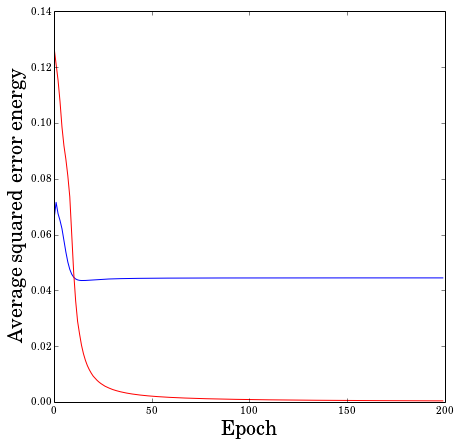

In [24]:
np.random.seed(10)
number_of_epochs = 200
mlp = MLP(np.array([2, 3, 1]), 0.15)

print "Number of inputs: " + str(mlp.number_of_inputs)
print "Number of layers: " + str(mlp.number_of_layers)
print "Number of hidden layers: " + str(mlp.number_of_hidden_layers)
print "Number of neurons per layer: " + str(mlp.number_of_neurons_per_layer)
print "Learning rate: " + str(mlp.learning_rate)

avg_square_error_std = mlp.std_backpropagation(training_set,number_of_epochs)
avg_square_error_rnd = mlp.backpropagation(training_set,number_of_epochs)

fig = plt.figure(figsize=(7,7))
plt.plot(avg_square_error_std);
plt.plot(avg_square_error_rnd,'r');
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Epoch',fontsize=20)
plt.ylabel(r'Average squared error energy',fontsize=20)

In [25]:
# Creacion del meshgrid para las curvas de nivel de los limites de decisión
delta = 0.00625
lower_left_corner = np.min(training_set[:,:-1])-20*delta
upper_right_corner = np.max(training_set[:,:-1])+20*delta
x1 = np.arange(lower_left_corner,upper_right_corner, delta)
x1, x2 = np.meshgrid(x1, x1)

y231 = np.zeros(shape=np.shape(x1))
for i in xrange(np.shape(x1)[0]):
    for j in xrange(np.shape(x1)[1]):
        y231[i,j] = mlp.feedforward(np.array([[x1[i,j]],[x2[i,j]]]).T)

mlp231 = np.zeros(shape=np.shape(training_target))
for i in xrange(training_target.shape[0]):
    mlp231[i] = mlp.feedforward(training_set[i,:-1,None].T)

    
mlp231_prediction = np.round(mlp231)==training_target
true_pred_indices = np.nonzero(mlp231_prediction==True)[0]


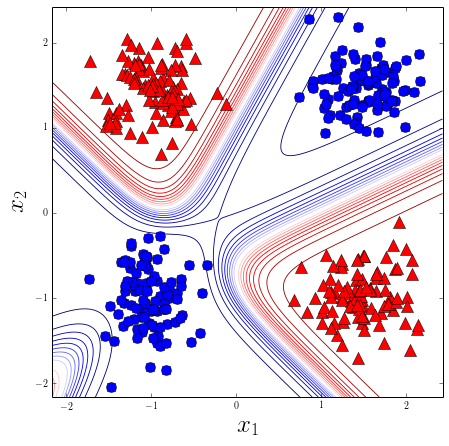

In [26]:
fig = plt.figure(figsize=(7,7))
levels = np.arange(-0.010, 1.010, 0.05)
plt.contour(y231, levels, origin='lower',linewidths=0.85, cmap=plt.get_cmap('seismic'), extent=(lower_left_corner,upper_right_corner,lower_left_corner,upper_right_corner))
CS = plt.contour(y231, [0], linewidths=1.25, cmap=plt.get_cmap('seismic'), extent=(lower_left_corner,upper_right_corner,lower_left_corner,upper_right_corner))

# fmt = {}
# for l,s in zip( CS.levels, [r'L\'imite de decisi\'on'] ):
#     fmt[l] = s
# plt.clabel(CS,CS.levels[::2],inline=True,fmt=fmt,fontsize=20, manual=[(1.3,-0.3),(1,1)])

trueNegIndices = np.intersect1d(negative_indices, true_pred_indices);
truePosIndices = np.intersect1d(positive_indices, true_pred_indices);
falseNegIndices = np.setdiff1d(positive_indices, truePosIndices);
falsePosIndices = np.setdiff1d(negative_indices, trueNegIndices);

plt.plot(training_set[trueNegIndices,0],training_set[trueNegIndices,1],'b',marker='o',markersize=10,linestyle='None');
plt.plot(training_set[truePosIndices,0],training_set[truePosIndices,1],'r',marker='^',markersize=12,linestyle='None');
plt.plot(training_set[falseNegIndices,0],training_set[falseNegIndices,1],'b',marker='^',markersize=12,linestyle='None');
plt.plot(training_set[falsePosIndices,0],training_set[falsePosIndices,1],'r',marker='o',markersize=10,linestyle='None');


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'$x_1$',fontsize=25)
plt.ylabel(r'$x_2$',fontsize=25)

# fig.savefig('Inteligencia Artificial/images/mlp231.eps',bbox_inches='tight', transparent=True)#, pad_inches=0)


In [27]:
# TODO: Average Squared Error must be a vector and not a scalar

# TODO: Make only one Backpropagation function

# TODO: Fix the Decision Boundary limit labels

# TODO: Add changing learning parameter